In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model

import matplotlib.pyplot  as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Paths and Constants
data_dir = '/kaggle/input/plant-seedlings-classification/train'  # Adjust to your actual data directory

# Get all image paths and labels
filepaths = []
labels = []
classes =[]
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, fname))
            labels.append(class_name)
    classes.append(class_name)

# Create a DataFrame
data_df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# Display first few rows of the DataFrame
print(data_df.head())

                                            filepath              label
0  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed
1  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed
2  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed
3  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed
4  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed


In [3]:
# Encode labels (optional if you need numeric labels)
data_df['label_encoded'] = data_df['label'].astype('category').cat.codes

# Split data into training, validation, and test sets
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Display the number of images in each set
print(f'Training set: {len(train_df)} images')
print(f'Validation set: {len(val_df)} images')
print(f'Test set: {len(test_df)} images')

Training set: 3040 images
Validation set: 760 images
Test set: 950 images


In [4]:
# Paths and Constants
img_height, img_width = 224, 224
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3040 validated image filenames belonging to 12 classes.
Found 760 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


In [6]:
classes, len(classes)

(['Scentless Mayweed',
  'Common wheat',
  'Charlock',
  'Black-grass',
  'Sugar beet',
  'Loose Silky-bent',
  'Maize',
  'Cleavers',
  'Common Chickweed',
  'Fat Hen',
  'Small-flowered Cranesbill',
  'Shepherds Purse'],
 12)

# Feature Extraction

In [7]:
# Model Setup
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model_feature = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(12, activation='softmax')  # 5 output units for 5 classes
])

# Compile the Model
model_feature.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Define the directory to save the models
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Create callbacks
checkpointer = ModelCheckpoint(filepath=os.path.join(models_dir, 'model_feature.keras'),  # Change to .keras
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

callbacks = [early_stopping, reduce_lr, checkpointer]

In [10]:
history1f = model_feature.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.7548 - loss: 0.7507 - val_accuracy: 0.7539 - val_loss: 0.7147
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 377ms/step - accuracy: 0.8414 - loss: 0.5112 - val_accuracy: 0.7947 - val_loss: 0.6491
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.8547 - loss: 0.4517 - val_accuracy: 0.7882 - val_loss: 0.6380
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 385ms/step - accuracy: 0.8857 - loss: 0.3495 - val_accuracy: 0.7868 - val_loss: 0.6379
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 385ms/step - accuracy: 0.9069 - loss: 0.2984 - val_accuracy: 0.7921 - val_loss: 0.6258
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.9189 - loss: 0.2680 - val_accuracy: 0.7974 - val_loss: 0.6152
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 391ms/step - accuracy: 0.9390 - loss: 0.2032 - val_accuracy: 0.7974 - val_loss: 0.6119
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 391ms/step - accuracy: 0.9488 - loss: 0.1853 - val_accu

In [11]:
train_accuracy = history1f.history['accuracy']
train_loss = history1f.history['loss']

# Validation accuracy and loss
val_accuracy = history1f.history['val_accuracy']
val_loss = history1f.history['val_loss']

In [12]:
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")

Final Training Accuracy: 0.9835526347160339
Final Training Loss: 0.061033036559820175
Final Validation Accuracy: 0.7934210300445557
Final Validation Loss: 0.9440231323242188


In [13]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

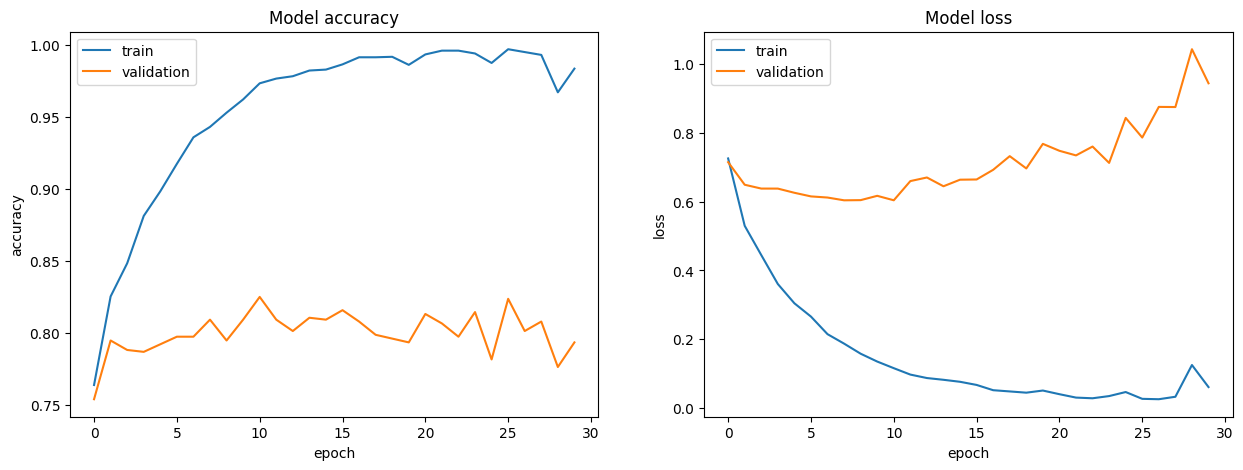

In [14]:
plot_train_history(history1f)

In [15]:
# Evaluate the Model on Test Data
test_loss, test_acc = model_feature.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 734ms/step - accuracy: 0.8080 - loss: 0.9300
Test Accuracy: 0.8042105436325073
Test Loss: 0.9110618233680725


In [17]:
# Generate predictions
predictions = model_feature.predict(test_generator, steps=len(test_generator))

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_generator.classes

30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step


In [18]:
len(predicted_classes)

950

In [19]:
def Confusion_Matrix(test_generator,predicted_classes):
    # Get true labels
    true_classes = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

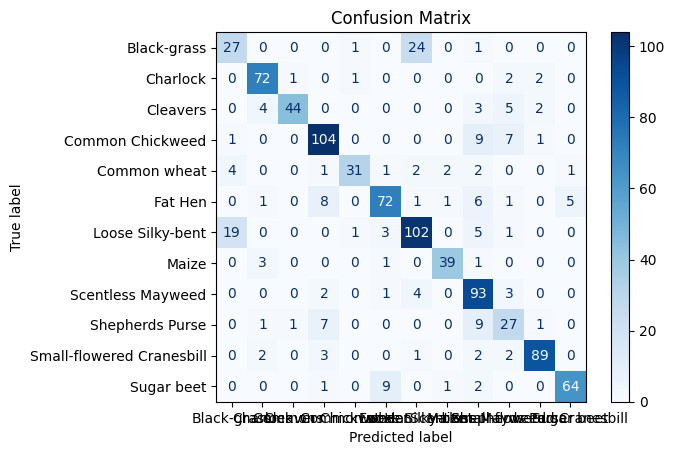

In [20]:
Confusion_Matrix(test_generator,predicted_classes)

In [23]:
def plot_image_prediction(test_generator, predicted_classes):
    # Convert class indices keys to a list for easy indexing
    class_names = list(test_generator.class_indices.keys())
    
    true_classes = test_generator.classes

    # Plot some test images with predictions
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = load_img(test_generator.filepaths[i], target_size=(img_height, img_width))  # Load the image
        plt.imshow(img)

        # Check if the prediction is correct
        if true_classes[i] == predicted_classes[i]:
            color = 'green'  # Correct prediction
        else:
            color = 'red'  # Incorrect prediction

        # Set the title with the corresponding color
        plt.title(f'True: {class_names[true_classes[i]]}, Pred: {class_names[predicted_classes[i]]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

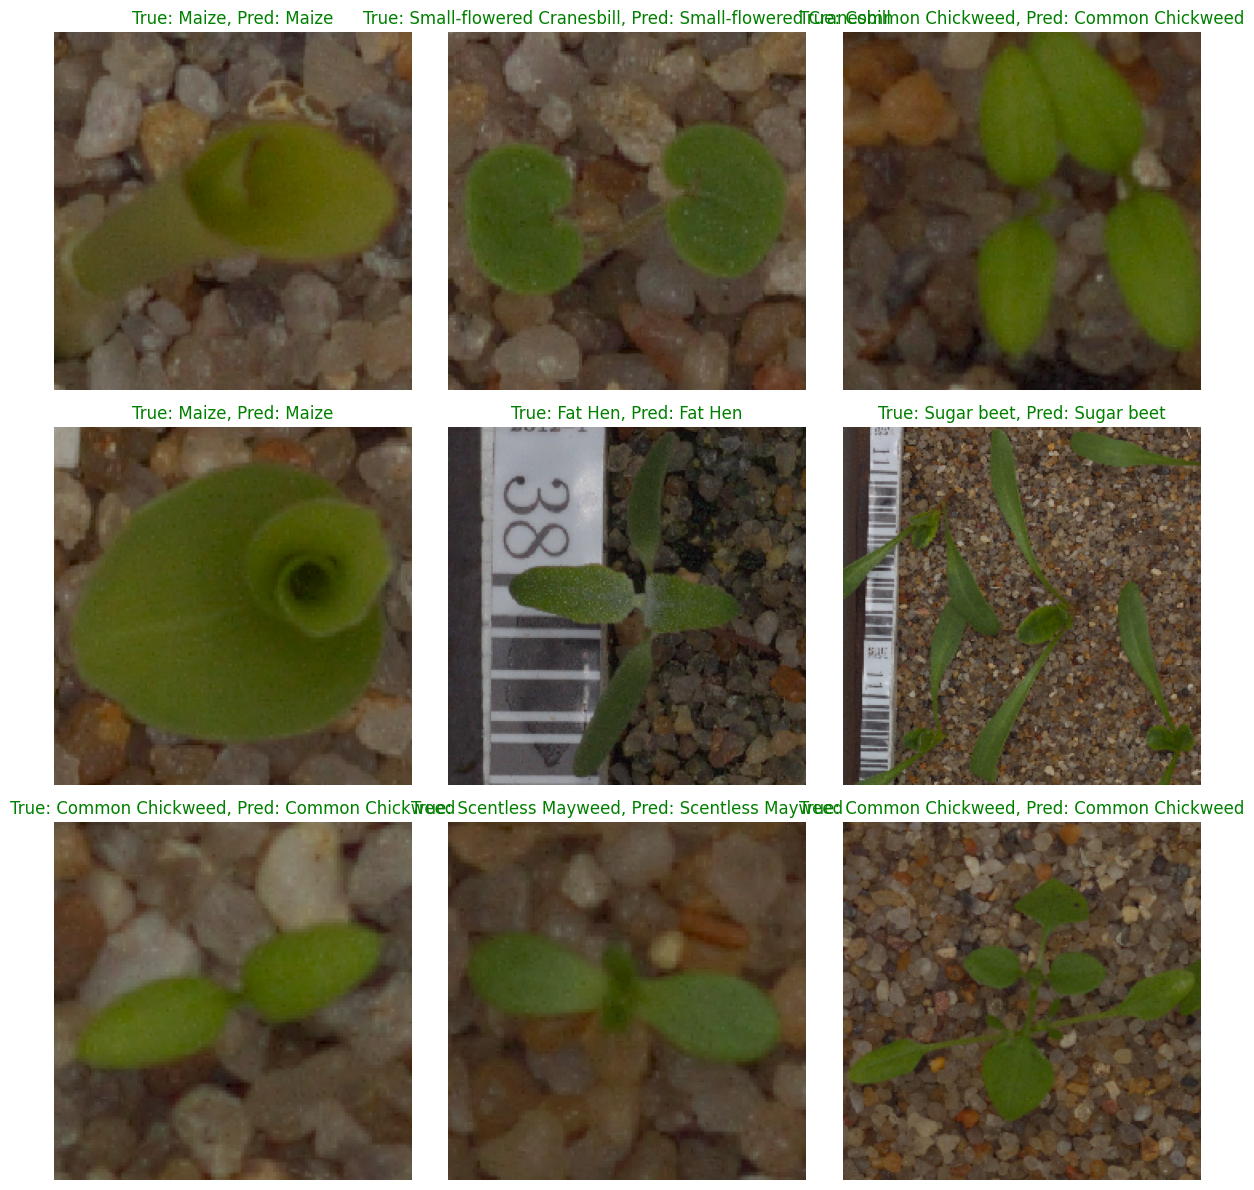

In [24]:
 plot_image_prediction(test_generator,predicted_classes)

In [25]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.53      0.51      0.52        53
                 Charlock       0.87      0.92      0.89        78
                 Cleavers       0.96      0.76      0.85        58
         Common Chickweed       0.83      0.85      0.84       122
             Common wheat       0.91      0.70      0.79        44
                  Fat Hen       0.83      0.76      0.79        95
         Loose Silky-bent       0.76      0.78      0.77       131
                    Maize       0.91      0.89      0.90        44
        Scentless Mayweed       0.70      0.90      0.79       103
          Shepherds Purse       0.56      0.59      0.57        46
Small-flowered Cranesbill       0.94      0.90      0.92        99
               Sugar beet       0.91      0.83      0.87        77

                 accuracy                           0.80       950
                macro avg       0.81      0.78      0.79    

In [26]:
# Save the model
model_feature.save('saved_models/xception_feature_100.keras')

In [27]:
output_dir="/kaggle/working/"

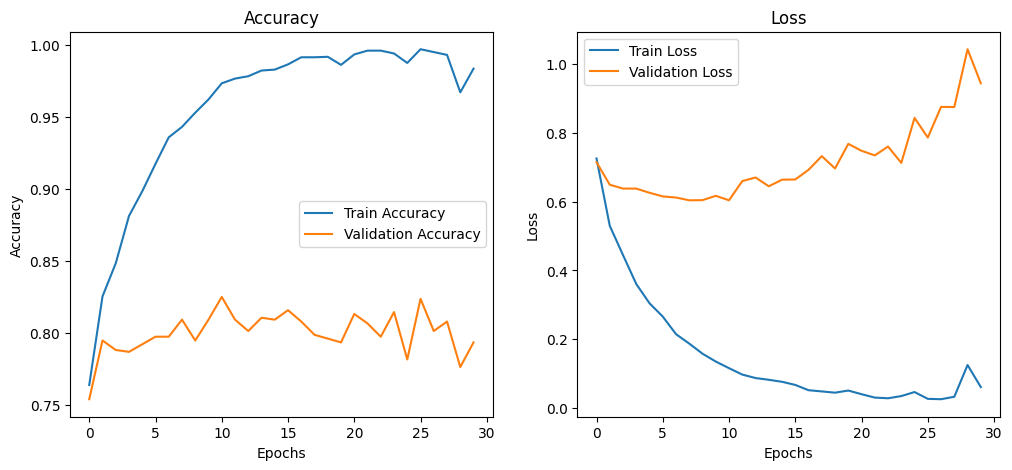

In [28]:
# Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.savefig(os.path.join(output_dir, "training_curves.png"))
    plt.show()

plot_training_curves(history1f)

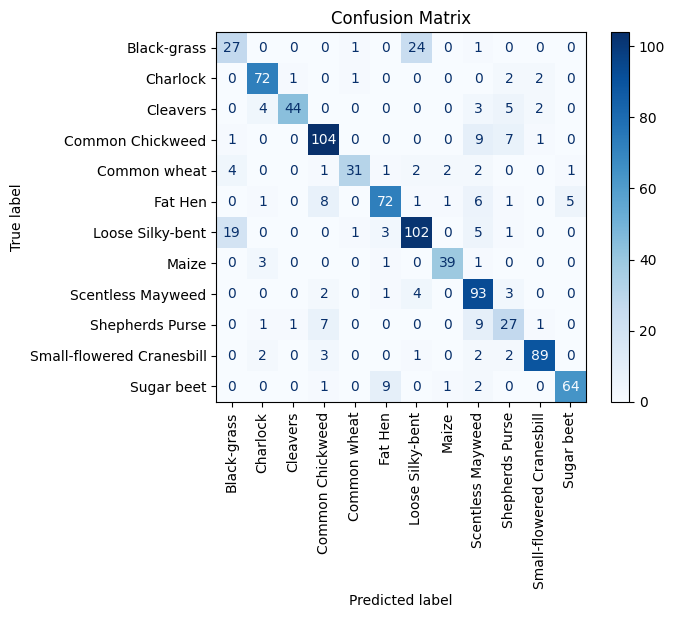

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=list(test_generator.class_indices.keys()))
cmd.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()


In [44]:
# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write(class_report)


In [31]:
# augmentation

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3040 validated image filenames belonging to 12 classes.
Found 760 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


In [33]:
# Model Setup
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model_feature = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(12, activation='softmax')  # 5 output units for 5 classes
])

# Compile the Model
model_feature.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Define the directory to save the models
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Create callbacks
checkpointer = ModelCheckpoint(filepath=os.path.join(models_dir, 'model_feature_aug_7.keras'),  # Change to .keras
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

callbacks = [early_stopping, reduce_lr, checkpointer]

In [36]:

historyfa = model_feature.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5205 - loss: 1.4761
Epoch 1: val_accuracy improved from -inf to 0.69605, saving model to saved_models/model_feature_aug_7.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 742ms/step - accuracy: 0.5208 - loss: 1.4746 - val_accuracy: 0.6961 - val_loss: 0.9639 - learning_rate: 0.0010
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.6793 - loss: 0.9732
Epoch 2: val_accuracy improved from 0.69605 to 0.72763, saving model to saved_models/model_feature_aug_7.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 71s 704ms/step - accuracy: 0.6793 - loss: 0.9732 - val_accuracy: 0.7276 - val_loss: 0.8236 - learning_rate: 0.0010
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7121 - loss: 0.8443
Epoch 3: val_accuracy improved from 0.72763 to 0.74737, saving model to saved_models/model_feature_aug_7.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 71s 706ms/step - accuracy: 0.7120 - loss: 0.8444 - val_accuracy: 0.7474 - val_loss: 0.7687 - learning

In [37]:
train_accuracy = historyfa.history['accuracy']
train_loss = historyfa.history['loss']

# Validation accuracy and loss
val_accuracy = historyfa.history['val_accuracy']
val_loss = historyfa.history['val_loss']

print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")


Final Training Accuracy: 0.8401315808296204
Final Training Loss: 0.45803171396255493
Final Validation Accuracy: 0.8289473652839661
Final Validation Loss: 0.5286948084831238


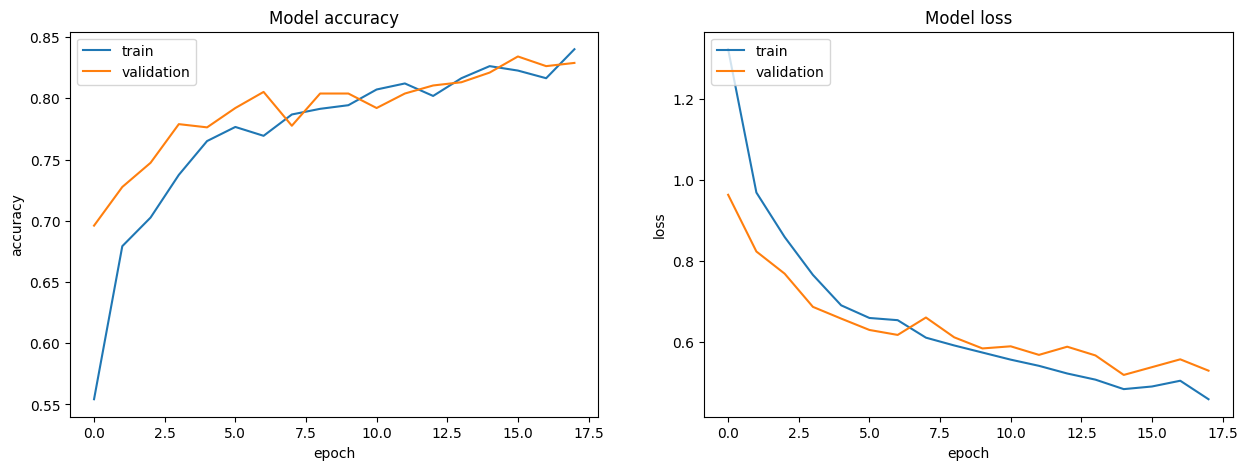

In [38]:
plot_train_history(historyfa)

In [39]:
# Evaluate the Model on Test Data
test_loss, test_acc = model_feature.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.8050 - loss: 0.5447
Test Accuracy: 0.8021052479743958
Test Loss: 0.5308802127838135


In [40]:
# Generate predictions
predictions = model_feature.predict(test_generator, steps=len(test_generator))

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step


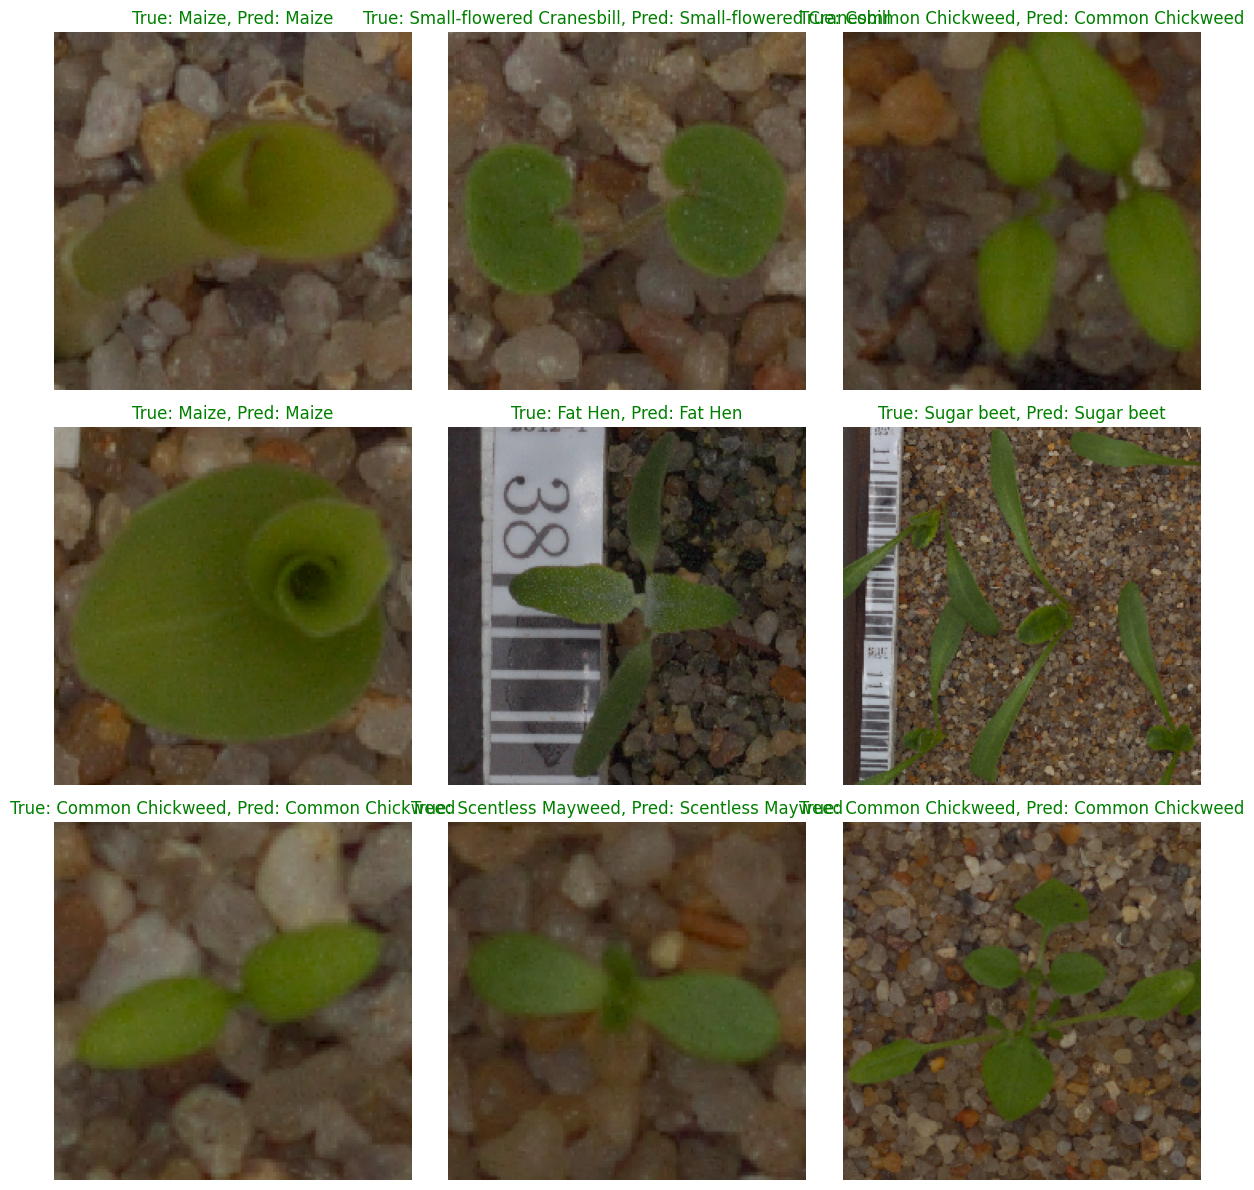

In [41]:
 plot_image_prediction(test_generator,predicted_classes)

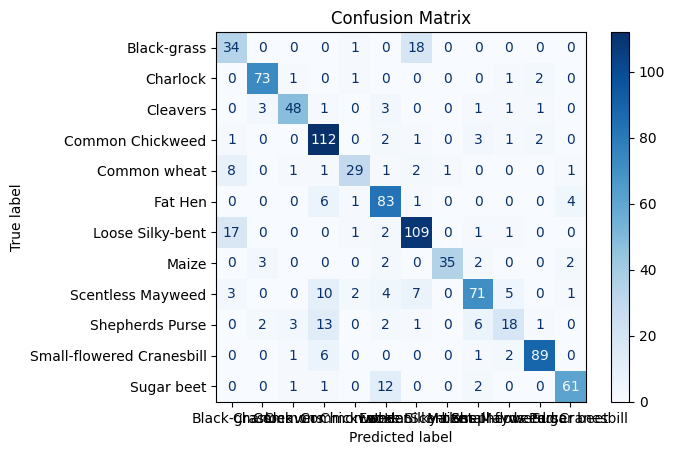

In [42]:
Confusion_Matrix(test_generator,predicted_classes)

In [43]:
true_classes=test_generator.classes

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.54      0.64      0.59        53
                 Charlock       0.90      0.94      0.92        78
                 Cleavers       0.87      0.83      0.85        58
         Common Chickweed       0.75      0.92      0.82       122
             Common wheat       0.83      0.66      0.73        44
                  Fat Hen       0.75      0.87      0.81        95
         Loose Silky-bent       0.78      0.83      0.81       131
                    Maize       0.97      0.80      0.88        44
        Scentless Mayweed       0.82      0.69      0.75       103
          Shepherds Purse       0.62      0.39      0.48        46
Small-flowered Cranesbill       0.94      0.90      0.92        99
               Sugar beet       0.88      0.79      0.84        77

                 accuracy                           0.80       950
                macro avg       0.80      0.77      0.78    